# Anomaly detection from raw images (all objects)

This Notebook serves a purpose to identify anomalies based on the patterns encoded in the raw images.

The current state of affairs in terms of using DL for anomaly detection is described well in [this paper](https://arxiv.org/abs/1901.03407)

### General idea

The general idea here is as follows: Can we use an unsupervised ML technique to train a model without giving it any labels to pick up the images, which are different from the majority of images?

It turns out that AutoEncoders can do it and have been used in the industry for mainly 3 purposes:
- compressing datasets
- denosing images
- anomaly detection

My strategy to automatically find the anomalous images will follow these steps:
- load raw images from the disk
- preprocess images
- split dataset into train and test sets
- define autoencoder architecture
- train autoencoder and analyse training results
- use test set and see which results produce highest error
- ability to find the error threshold based on the percentage of anomalies (if we know that number)

### Challenges / experiments to perform:

There are many questions about this experiment and many ways of trying it. Here are the main questions, which I will try to answer in my analysis:
- should we split the datsets by class or perform one training for all classes and let algorithm find anomalies?
- how many images do we need to be representative? (whole dataset is over 300K samples)?
- what resolution should images be?
- should other image preprocessing tricks be applied (thresholding for example)?
- what is the impact of including only the area of interest and hiding the terrain outside of the parking slot?
- if vanila autoencoder does not do a good job, can variational autoencoder do it better?

Paper on AutoEncoders to review [here](https://arxiv.org/pdf/1606.08921.pdf)

In [1]:
# import ConfigImports Notebook to import and configure libs
%run ../ConfigImports.ipynb

TF -> Using GPU ->  PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


### Load dataset and clean it up

First, lets load a dataframe with all image dates and filenames from a previously stored parquet file.

Then lets remove the outage dates.

In [3]:
df = pd.read_parquet('../Datasets/AllObjectDetections_2019-09-09_2020-03-02.parquet.gzip')
df = df.drop(labels=['index'], axis=1)
df.head(2)

,img_idx,label,confidence,x1,y1,x2,y2,date,time,filename,img_n_boxes,time_ms,date_time,week_day,is_weekend,month,hour,min
0,72846,car,0.523175,298,7,426,71,2019-09-09,07.02.40,07.02.40.270_34c99836_car-car-car.jpg,1,270,2019-09-09 07:02:40.270,Monday,False,9,7,2
1,72847,person,0.759682,489,31,518,106,2019-09-09,12.02.42,12.02.42.921_ea6c9143_person-bicycle.jpg,2,921,2019-09-09 12:02:42.921,Monday,False,9,12,2


In [4]:
FAULTY_DATES = ['2020-01-13', '2020-01-14', '2020-02-28']
idx = df['date'].isin(FAULTY_DATES)
df = df.loc[~idx]
df.shape

(643471, 18)

### Define helper functions using Computer Vision techniques

First of, we need a quick way of displaying images in the Notebook. This is handled by the `imshow` function below, which is flexible enough to handle 3 types of inputs to display an image:
- image file path
- image as numpy array
- grayscale and color images

Next, I have defined the `process_frame` function, which allows to perform following operations on an image using flags as function arguments:
- convert to gray scale 
- apply Gaussian blur
- apply thresholding
- crop region of interest using polyfill

In [6]:
def imshow(img, width=12, height=6):
    """
    Show image using matplotlib. Function takes a path or a 
    numpy image and renders it in RBG color-space
    """
    if isinstance(img, str):
        img = cv2.imread(img)
    rcParams['figure.figsize'] = width, height
    plt.axis('off')
    print(img.shape)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB));
    plt.show()

def process_frame(frame, dims, is_gray=True, is_blur=False, is_thresh=False, is_polyfill=False,
                  poly_values=None, debug_poly=False):
    """
    Preprocess frame for Machine Learning:    
    - resize to desired size to improve performance and reduce noise
    - change to gray scale to improve performance and remove color variances
    - apply Gaussian blur to remove noise
    - threshold to partition an image into foreground and background
    - mask out an area of an image bases on a poly shape
    """
    if frame is None or frame.shape[0] == 0:
        raise ValueError('Error: issue with frame!')
    frame = cv2.resize(frame, dims)
    if is_gray:
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
    if is_blur:
        frame = cv2.GaussianBlur(frame, (5, 5), 0)
    if is_thresh:
        _, frame = cv2.threshold(frame, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    if is_polyfill:
        wh  = np.array([frame.shape[0], frame.shape[1]])
        poly_shape = np.array([poly_values * wh]).astype(np.int32)
        cv2.fillConvexPoly(frame, poly_shape, (0, 0, 0))
        if debug_poly:
            for points in poly_shape:
                for i, p in enumerate(points):
                    text_points = (p[0] + 2 if p[0] < wh[0] else p[0] - 18, p[1] + 24)
                    frame = cv2.circle(frame, tuple(p), 3, (0,255,0), 3)
                    cv2.putText(frame, str(i), text_points, cv2.FONT_HERSHEY_SIMPLEX, 
                            0.7, (0,0,255), 2)
    return frame

### Example frame processed

In [14]:
# Todo: show all possible image processing based on the same image (render as 2x2 plot-grid)
72 / 8

9.0

### Automated parameter test

There is so many permutations of potential options to select here that it cna get overwheling very quickly.

What I have decided to do is to define a list of all parameters I would like to test and use Pythons `itertools.product` function to create a cartesian product of all parameters, and then test them all in a single loop, which can run overnight without a need to manually re-run the model.

In [7]:
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam

In [9]:
# test parameters automatically and see what is classified as anomaly
import itertools

histories = {}
real_params = ((10000, 25000, 50000), (28, 56, 112), (False, True), (False, True), (False, True))
test_params = ((200, 300), (28, 56), (False, True), (False, True), (False, True))

IMG_BASE_DIR = '/data/security_cam_detections_v2/Front-Parking'

for n_samples, dim, is_blur, is_thresh, is_poly in itertools.product(*real_params):
    model_name = f'nsamples{n_samples}_res{dim}_blur{is_blur}_thresh{is_thresh}_poly{is_poly}'
    print(f'Running model: *{model_name}*')
    print(f'Time is: {str(dt.now())}')
    
    dest_file_data = f'../Datasets/raw_images_processed/img__{model_name}.npy'
    dest_file_filenames = f'../Datasets/raw_images_processed/filepaths__{model_name}.npy'

    # how many rows to sample from dataframe
    NUM_ROWS = n_samples

    # resize images from 1080p to these dimensions
    WIDTH, HEIGHT = dim, dim
    
    # if polyfill is used, use this percentage mask to cover the top area of image
    POLY_VALUES = np.array([[0, 0], [1, 0], [1, 0.37], [0.5, 0.21], [0.25, 0.13], [0, 0.09]])  # poly-shape to mask
    
    # try:
    #     # load files from disk, if don't exist, generate samples from the dataframe
    #     im_data = np.load(dest_file_data)
    #     im_filepaths = np.load(dest_file_filenames)
    # except Exception as e:
        # pre-allocate memory for the numpy array
    im_data = np.zeros((NUM_ROWS, WIDTH, HEIGHT), dtype='uint8')
    im_filepaths = []

    # sample rows from the dataframe
    samples = df.sample(NUM_ROWS)

    # iterate through images and store in previously defined numpy array
    im_processed_prev = None
    im_path_prev = None
    for i, (im_date, im_filename) in tqdm(enumerate(samples[['date', 'filename']].to_numpy())):
        im_path = f'{IMG_BASE_DIR}/{im_date}/{im_filename}'
        im_raw = cv2.imread(im_path)
        try:
            im_processed = process_frame(im_raw, (WIDTH, HEIGHT), is_gray=True, is_blur=is_blur,
                                         is_thresh=is_thresh, is_polyfill=is_poly, poly_values=POLY_VALUES)
        except Exception as e:
            # if exception occurs when reading image, use previous image again
            print('Exception, will use previous image instead.', str(e), im_path)
            im_data[i] = im_processed_prev
            im_filepaths.append(im_path_prev)
            continue
        im_processed_prev = im_processed.copy()
        im_path_prev = im_path
        im_data[i] = im_processed
        im_filepaths.append(im_path)
    im_filepaths = np.array(im_filepaths)

    # save numpy arrays in the Datasets (efficient binary format)
    np.save(dest_file_data, im_data)
    np.save(dest_file_filenames, im_filepaths)

    # print useful info
    print(f"Sampled {round(NUM_ROWS / df.shape[0], 2) * 100} % of data, {NUM_ROWS} out of {df.shape[0]} data points")
    print(f'Data shape: {im_data.shape}')
    print(f'Data size in RAM: {round((im_data.size * im_data.itemsize) / 1024 / 1024, 2)} MB')
    
    # add a channel dimension to every image in the dataset, then scale
    # the pixel intensities to the range [0, 1]
    im_data = np.squeeze(im_data)
    im_data = np.expand_dims(im_data, axis=-1)
    im_data = im_data.astype("float32") / 255.0
    print(f'Data reshaped shape: {im_data.shape}')

    # construct the training and testing split
    X_train, X_test, y_train, y_test = train_test_split(im_data, im_filepaths, test_size=0.2, random_state=42)
    print(f'Train shape: {X_train.shape}, test shape: {X_test.shape}')
    
    # define model params
    latent_dim=16
    depth = 1
    input_shape = (HEIGHT, WIDTH, depth)
    chan_dim = -1

    # CNN filters
    filters=(32, 64)

    # define the input to the encoder
    inputs = Input(shape=input_shape)
    x = inputs
    # loop over the number of filters
    for f in filters:
        # apply a CONV => RELU => BN operation
        x = Conv2D(f, (3, 3), strides=2, padding="same")(x)
        x = LeakyReLU(alpha=0.2)(x)
        x = BatchNormalization(axis=chan_dim)(x)
    # flatten the network and then construct our latent vector
    volume_size = K.int_shape(x)
    x = Flatten()(x)
    latent = Dense(latent_dim)(x)
    # build the encoder model
    encoder = Model(inputs, latent, name="encoder")

    # start building the decoder model which will accept the
    # output of the encoder as its inputs
    latent_inputs = Input(shape=(latent_dim,))
    x = Dense(np.prod(volume_size[1:]))(latent_inputs)
    x = Reshape((volume_size[1], volume_size[2], volume_size[3]))(x)
    # loop over our number of filters again, but this time in
    # reverse order
    for f in filters[::-1]:
        # apply a CONV_TRANSPOSE => RELU => BN operation
        x = Conv2DTranspose(f, (3, 3), strides=2, padding="same")(x)
        x = LeakyReLU(alpha=0.2)(x)
        x = BatchNormalization(axis=chan_dim)(x)
    # apply a single CONV_TRANSPOSE layer used to recover the
    # original depth of the image
    x = Conv2DTranspose(depth, (3, 3), padding="same")(x)
    outputs = Activation("sigmoid")(x)
    # build the decoder model
    decoder = Model(latent_inputs, outputs, name="decoder")

    # our autoencoder is the encoder + decoder
    autoencoder = Model(inputs, decoder(encoder(inputs)), name="autoencoder")

    # initialize the number of epochs to train for, initial learning rate,
    # and batch size
    EPOCHS = 50
    INIT_LR = 1e-3
    BS = 32

    opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
    autoencoder.compile(loss="mse", optimizer=opt)
    
    # train the convolutional autoencoder,
    # note that the labels are actually the same
    # as the training data
    # save history data for later analysis
    H = autoencoder.fit(X_train, X_train, validation_data=(X_test, X_test),
                        epochs=EPOCHS, batch_size=BS, verbose=0)  # verbose to 0 to silence it
    histories[model_name] = {'loss': H.history["loss"], 'val_loss': H.history["val_loss"], 'ts': str(dt.now())}
    
    # reconstruct data
    reconstructed_data = autoencoder.predict(X_test)
    
    # calculate errors for test-set
    errors = []
    for (image, recon) in zip(X_test, reconstructed_data):
        # compute the mean squared error between the ground-truth image
        # and the reconstructed image, then add it to our list of errors
        mse = np.mean((image - recon) ** 2)
        errors.append(mse)
    errors = np.array(errors)
    
    # compute the q-th quantile of the errors which serves as our
    # threshold to identify anomalies -- any data point that our model
    # reconstructed with > threshold error will be marked as an outlier
    thresh = np.quantile(errors, 0.997)
    idxs = np.where(np.array(errors) >= thresh)[0]
    print(f"Mse threshold: {thresh}")
    print(f"Outliers found: {len(idxs)}")
    
    # take a look at a few images with highest error
    errors_df = pd.DataFrame({'mse': errors, 'y_test': y_test})
    errors_df['is_anomaly'] = 'N'
    errors_df.loc[errors_df['mse'] >= thresh, 'is_anomaly'] = 'Y'
    errors_df = errors_df.sort_values('mse', ascending=False)
    csv_filename = f'../Datasets/anomaly_results/{model_name}.csv'
    errors_df.head(10).to_csv(csv_filename, index=False)
    print('*******************************')

now = str(dt.now())
filename = f'../Datasets/histories/history_run_{now}.pickle'
outfile = open(filename, 'wb')
pickle.dump(histories, outfile)
outfile.close()
print(f'Done. Time is {now}')

Running model: *nsamples10000_res28_blurFalse_threshFalse_polyFalse*
Time is: 2020-05-31 08:46:08.143371



Sampled 2.0 % of data, 10000 out of 643471 data points
Data shape: (10000, 28, 28)
Data size in RAM: 7.48 MB
Data reshaped shape: (10000, 28, 28, 1)
Train shape: (8000, 28, 28, 1), test shape: (2000, 28, 28, 1)
Mse threshold: 0.030151297187432567
Outliers found: 6
*******************************
Running model: *nsamples10000_res28_blurFalse_threshFalse_polyTrue*
Time is: 2020-05-31 08:49:23.081301



Sampled 2.0 % of data, 10000 out of 643471 data points
Data shape: (10000, 28, 28)
Data size in RAM: 7.48 MB
Data reshaped shape: (10000, 28, 28, 1)
Train shape: (8000, 28, 28, 1), test shape: (2000, 28, 28, 1)
Mse threshold: 0.02641601513884939
Outliers found: 6
*******************************
Running model: *nsamples10000_res28_blurFalse_threshTrue_polyFalse*
Time is: 2020-05-31 08:52:35.226835



Sampled 2.0 % of data, 10000 out of 643471 data points
Data shape: (10000, 28, 28)
Data size in RAM: 7.48 MB
Data reshaped shape: (10000, 28, 28, 1)
Train shape: (8000, 28, 28, 1), test shape: (2000, 28, 28, 1)
Mse threshold: 0.12844278384745098
Outliers found: 6
*******************************
Running model: *nsamples10000_res28_blurFalse_threshTrue_polyTrue*
Time is: 2020-05-31 08:55:45.842360



Sampled 2.0 % of data, 10000 out of 643471 data points
Data shape: (10000, 28, 28)
Data size in RAM: 7.48 MB
Data reshaped shape: (10000, 28, 28, 1)
Train shape: (8000, 28, 28, 1), test shape: (2000, 28, 28, 1)
Mse threshold: 0.11257517378032166
Outliers found: 6
*******************************
Running model: *nsamples10000_res28_blurTrue_threshFalse_polyFalse*
Time is: 2020-05-31 08:58:57.021529



Sampled 2.0 % of data, 10000 out of 643471 data points
Data shape: (10000, 28, 28)
Data size in RAM: 7.48 MB
Data reshaped shape: (10000, 28, 28, 1)
Train shape: (8000, 28, 28, 1), test shape: (2000, 28, 28, 1)
Mse threshold: 0.0066356908311135995
Outliers found: 6
*******************************
Running model: *nsamples10000_res28_blurTrue_threshFalse_polyTrue*
Time is: 2020-05-31 09:02:07.526526



Sampled 2.0 % of data, 10000 out of 643471 data points
Data shape: (10000, 28, 28)
Data size in RAM: 7.48 MB
Data reshaped shape: (10000, 28, 28, 1)
Train shape: (8000, 28, 28, 1), test shape: (2000, 28, 28, 1)
Mse threshold: 0.006196196097414931
Outliers found: 6
*******************************
Running model: *nsamples10000_res28_blurTrue_threshTrue_polyFalse*
Time is: 2020-05-31 09:05:18.694185



Sampled 2.0 % of data, 10000 out of 643471 data points
Data shape: (10000, 28, 28)
Data size in RAM: 7.48 MB
Data reshaped shape: (10000, 28, 28, 1)
Train shape: (8000, 28, 28, 1), test shape: (2000, 28, 28, 1)
Mse threshold: 0.09182971655577414
Outliers found: 6
*******************************
Running model: *nsamples10000_res28_blurTrue_threshTrue_polyTrue*
Time is: 2020-05-31 09:08:30.387377



Sampled 2.0 % of data, 10000 out of 643471 data points
Data shape: (10000, 28, 28)
Data size in RAM: 7.48 MB
Data reshaped shape: (10000, 28, 28, 1)
Train shape: (8000, 28, 28, 1), test shape: (2000, 28, 28, 1)
Mse threshold: 0.08234064362198067
Outliers found: 6
*******************************
Running model: *nsamples10000_res56_blurFalse_threshFalse_polyFalse*
Time is: 2020-05-31 09:11:42.902396



Sampled 2.0 % of data, 10000 out of 643471 data points
Data shape: (10000, 56, 56)
Data size in RAM: 29.91 MB
Data reshaped shape: (10000, 56, 56, 1)
Train shape: (8000, 56, 56, 1), test shape: (2000, 56, 56, 1)
Mse threshold: 0.03275439545139667
Outliers found: 6
*******************************
Running model: *nsamples10000_res56_blurFalse_threshFalse_polyTrue*
Time is: 2020-05-31 09:15:10.788513



Sampled 2.0 % of data, 10000 out of 643471 data points
Data shape: (10000, 56, 56)
Data size in RAM: 29.91 MB
Data reshaped shape: (10000, 56, 56, 1)
Train shape: (8000, 56, 56, 1), test shape: (2000, 56, 56, 1)
Mse threshold: 0.028697996666654887
Outliers found: 6
*******************************
Running model: *nsamples10000_res56_blurFalse_threshTrue_polyFalse*
Time is: 2020-05-31 09:18:33.345452


Exception, will use previous image instead. Error: issue with frame! /data/security_cam_detections_v2/Front-Parking/2020-02-08/23.33.41.278_955bc21c_person.jpg

Sampled 2.0 % of data, 10000 out of 643471 data points
Data shape: (10000, 56, 56)
Data size in RAM: 29.91 MB
Data reshaped shape: (10000, 56, 56, 1)
Train shape: (8000, 56, 56, 1), test shape: (2000, 56, 56, 1)
Mse threshold: 0.12242201250046483
Outliers found: 6
*******************************
Running model: *nsamples10000_res56_blurFalse_threshTrue_polyTrue*
Time is: 2020-05-31 09:21:56.575836



Sampled 2.0 % of data, 10000 out of 643471 data points
Data shape: (10000, 56, 56)
Data size in RAM: 29.91 MB
Data reshaped shape: (10000, 56, 56, 1)
Train shape: (8000, 56, 56, 1), test shape: (2000, 56, 56, 1)
Mse threshold: 0.09791737712919707
Outliers found: 6
*******************************
Running model: *nsamples10000_res56_blurTrue_threshFalse_polyFalse*
Time is: 2020-05-31 09:25:41.799927



Sampled 2.0 % of data, 10000 out of 643471 data points
Data shape: (10000, 56, 56)
Data size in RAM: 29.91 MB
Data reshaped shape: (10000, 56, 56, 1)
Train shape: (8000, 56, 56, 1), test shape: (2000, 56, 56, 1)
Mse threshold: 0.012739982211962339
Outliers found: 6
*******************************
Running model: *nsamples10000_res56_blurTrue_threshFalse_polyTrue*
Time is: 2020-05-31 09:29:23.179365


Exception, will use previous image instead. Error: issue with frame! /data/security_cam_detections_v2/Front-Parking/2020-01-25/23.32.10.480_afdcd96f_car.jpg

Sampled 2.0 % of data, 10000 out of 643471 data points
Data shape: (10000, 56, 56)
Data size in RAM: 29.91 MB
Data reshaped shape: (10000, 56, 56, 1)
Train shape: (8000, 56, 56, 1), test shape: (2000, 56, 56, 1)
Mse threshold: 0.012064086535014156
Outliers found: 6
*******************************
Running model: *nsamples10000_res56_blurTrue_threshTrue_polyFalse*
Time is: 2020-05-31 09:33:06.865564



Sampled 2.0 % of data, 10000 out of 643471 data points
Data shape: (10000, 56, 56)
Data size in RAM: 29.91 MB
Data reshaped shape: (10000, 56, 56, 1)
Train shape: (8000, 56, 56, 1), test shape: (2000, 56, 56, 1)
Mse threshold: 0.1023946270942687
Outliers found: 6
*******************************
Running model: *nsamples10000_res56_blurTrue_threshTrue_polyTrue*
Time is: 2020-05-31 09:36:51.386676



Sampled 2.0 % of data, 10000 out of 643471 data points
Data shape: (10000, 56, 56)
Data size in RAM: 29.91 MB
Data reshaped shape: (10000, 56, 56, 1)
Train shape: (8000, 56, 56, 1), test shape: (2000, 56, 56, 1)
Mse threshold: 0.08426738838106385
Outliers found: 6
*******************************
Running model: *nsamples10000_res112_blurFalse_threshFalse_polyFalse*
Time is: 2020-05-31 09:40:35.603504



Sampled 2.0 % of data, 10000 out of 643471 data points
Data shape: (10000, 112, 112)
Data size in RAM: 119.63 MB
Data reshaped shape: (10000, 112, 112, 1)
Train shape: (8000, 112, 112, 1), test shape: (2000, 112, 112, 1)
Mse threshold: 0.028746331680566048
Outliers found: 6
*******************************
Running model: *nsamples10000_res112_blurFalse_threshFalse_polyTrue*
Time is: 2020-05-31 09:46:54.107277



Sampled 2.0 % of data, 10000 out of 643471 data points
Data shape: (10000, 112, 112)
Data size in RAM: 119.63 MB
Data reshaped shape: (10000, 112, 112, 1)
Train shape: (8000, 112, 112, 1), test shape: (2000, 112, 112, 1)
Mse threshold: 0.023956486996263165
Outliers found: 6
*******************************
Running model: *nsamples10000_res112_blurFalse_threshTrue_polyFalse*
Time is: 2020-05-31 09:53:12.969590



Sampled 2.0 % of data, 10000 out of 643471 data points
Data shape: (10000, 112, 112)
Data size in RAM: 119.63 MB
Data reshaped shape: (10000, 112, 112, 1)
Train shape: (8000, 112, 112, 1), test shape: (2000, 112, 112, 1)
Mse threshold: 0.1080172287300227
Outliers found: 6
*******************************
Running model: *nsamples10000_res112_blurFalse_threshTrue_polyTrue*
Time is: 2020-05-31 09:59:32.021380



Sampled 2.0 % of data, 10000 out of 643471 data points
Data shape: (10000, 112, 112)
Data size in RAM: 119.63 MB
Data reshaped shape: (10000, 112, 112, 1)
Train shape: (8000, 112, 112, 1), test shape: (2000, 112, 112, 1)
Mse threshold: 0.10136733427643772
Outliers found: 6
*******************************
Running model: *nsamples10000_res112_blurTrue_threshFalse_polyFalse*
Time is: 2020-05-31 10:05:51.572274



Sampled 2.0 % of data, 10000 out of 643471 data points
Data shape: (10000, 112, 112)
Data size in RAM: 119.63 MB
Data reshaped shape: (10000, 112, 112, 1)
Train shape: (8000, 112, 112, 1), test shape: (2000, 112, 112, 1)
Mse threshold: 0.016775282131507942
Outliers found: 6
*******************************
Running model: *nsamples10000_res112_blurTrue_threshFalse_polyTrue*
Time is: 2020-05-31 10:12:11.744040



Sampled 2.0 % of data, 10000 out of 643471 data points
Data shape: (10000, 112, 112)
Data size in RAM: 119.63 MB
Data reshaped shape: (10000, 112, 112, 1)
Train shape: (8000, 112, 112, 1), test shape: (2000, 112, 112, 1)
Mse threshold: 0.0167347288560122
Outliers found: 6
*******************************
Running model: *nsamples10000_res112_blurTrue_threshTrue_polyFalse*
Time is: 2020-05-31 10:18:31.789920



Sampled 2.0 % of data, 10000 out of 643471 data points
Data shape: (10000, 112, 112)
Data size in RAM: 119.63 MB
Data reshaped shape: (10000, 112, 112, 1)
Train shape: (8000, 112, 112, 1), test shape: (2000, 112, 112, 1)
Mse threshold: 0.11818515797704447
Outliers found: 6
*******************************
Running model: *nsamples10000_res112_blurTrue_threshTrue_polyTrue*
Time is: 2020-05-31 10:24:52.436819



Sampled 2.0 % of data, 10000 out of 643471 data points
Data shape: (10000, 112, 112)
Data size in RAM: 119.63 MB
Data reshaped shape: (10000, 112, 112, 1)
Train shape: (8000, 112, 112, 1), test shape: (2000, 112, 112, 1)
Mse threshold: 0.08583414074033478
Outliers found: 6
*******************************
Running model: *nsamples25000_res28_blurFalse_threshFalse_polyFalse*
Time is: 2020-05-31 10:31:12.906143



Sampled 4.0 % of data, 25000 out of 643471 data points
Data shape: (25000, 28, 28)
Data size in RAM: 18.69 MB
Data reshaped shape: (25000, 28, 28, 1)
Train shape: (20000, 28, 28, 1), test shape: (5000, 28, 28, 1)
Mse threshold: 0.026877195367589472
Outliers found: 15
*******************************
Running model: *nsamples25000_res28_blurFalse_threshFalse_polyTrue*
Time is: 2020-05-31 10:39:30.119804



Sampled 4.0 % of data, 25000 out of 643471 data points
Data shape: (25000, 28, 28)
Data size in RAM: 18.69 MB
Data reshaped shape: (25000, 28, 28, 1)
Train shape: (20000, 28, 28, 1), test shape: (5000, 28, 28, 1)
Mse threshold: 0.024165811579674304
Outliers found: 15
*******************************
Running model: *nsamples25000_res28_blurFalse_threshTrue_polyFalse*
Time is: 2020-05-31 10:47:49.438767



Sampled 4.0 % of data, 25000 out of 643471 data points
Data shape: (25000, 28, 28)
Data size in RAM: 18.69 MB
Data reshaped shape: (25000, 28, 28, 1)
Train shape: (20000, 28, 28, 1), test shape: (5000, 28, 28, 1)
Mse threshold: 0.11095449588447794
Outliers found: 15
*******************************
Running model: *nsamples25000_res28_blurFalse_threshTrue_polyTrue*
Time is: 2020-05-31 10:56:11.652770


Exception, will use previous image instead. Error: issue with frame! /data/security_cam_detections_v2/Front-Parking/2020-01-25/23.32.10.990_4c062cda_car.jpg

Sampled 4.0 % of data, 25000 out of 643471 data points
Data shape: (25000, 28, 28)
Data size in RAM: 18.69 MB
Data reshaped shape: (25000, 28, 28, 1)
Train shape: (20000, 28, 28, 1), test shape: (5000, 28, 28, 1)
Mse threshold: 0.08937916464358543
Outliers found: 15
*******************************
Running model: *nsamples25000_res28_blurTrue_threshFalse_polyFalse*
Time is: 2020-05-31 11:04:35.832475



Sampled 4.0 % of data, 25000 out of 643471 data points
Data shape: (25000, 28, 28)
Data size in RAM: 18.69 MB
Data reshaped shape: (25000, 28, 28, 1)
Train shape: (20000, 28, 28, 1), test shape: (5000, 28, 28, 1)
Mse threshold: 0.00612341901380566
Outliers found: 15
*******************************
Running model: *nsamples25000_res28_blurTrue_threshFalse_polyTrue*
Time is: 2020-05-31 11:12:24.178298



Sampled 4.0 % of data, 25000 out of 643471 data points
Data shape: (25000, 28, 28)
Data size in RAM: 18.69 MB
Data reshaped shape: (25000, 28, 28, 1)
Train shape: (20000, 28, 28, 1), test shape: (5000, 28, 28, 1)
Mse threshold: 0.004626421972643579
Outliers found: 15
*******************************
Running model: *nsamples25000_res28_blurTrue_threshTrue_polyFalse*
Time is: 2020-05-31 11:20:20.818446



Sampled 4.0 % of data, 25000 out of 643471 data points
Data shape: (25000, 28, 28)
Data size in RAM: 18.69 MB
Data reshaped shape: (25000, 28, 28, 1)
Train shape: (20000, 28, 28, 1), test shape: (5000, 28, 28, 1)
Mse threshold: 0.08949109727889239
Outliers found: 15
*******************************
Running model: *nsamples25000_res28_blurTrue_threshTrue_polyTrue*
Time is: 2020-05-31 11:28:16.925692



Sampled 4.0 % of data, 25000 out of 643471 data points
Data shape: (25000, 28, 28)
Data size in RAM: 18.69 MB
Data reshaped shape: (25000, 28, 28, 1)
Train shape: (20000, 28, 28, 1), test shape: (5000, 28, 28, 1)
Mse threshold: 0.07008396092802263
Outliers found: 15
*******************************
Running model: *nsamples25000_res56_blurFalse_threshFalse_polyFalse*
Time is: 2020-05-31 11:36:10.815416



Sampled 4.0 % of data, 25000 out of 643471 data points
Data shape: (25000, 56, 56)
Data size in RAM: 74.77 MB
Data reshaped shape: (25000, 56, 56, 1)
Train shape: (20000, 56, 56, 1), test shape: (5000, 56, 56, 1)
Mse threshold: 0.027343688230961536
Outliers found: 15
*******************************
Running model: *nsamples25000_res56_blurFalse_threshFalse_polyTrue*
Time is: 2020-05-31 11:45:11.219424



Sampled 4.0 % of data, 25000 out of 643471 data points
Data shape: (25000, 56, 56)
Data size in RAM: 74.77 MB
Data reshaped shape: (25000, 56, 56, 1)
Train shape: (20000, 56, 56, 1), test shape: (5000, 56, 56, 1)
Mse threshold: 0.024945608850568454
Outliers found: 15
*******************************
Running model: *nsamples25000_res56_blurFalse_threshTrue_polyFalse*
Time is: 2020-05-31 11:54:10.912374



Sampled 4.0 % of data, 25000 out of 643471 data points
Data shape: (25000, 56, 56)
Data size in RAM: 74.77 MB
Data reshaped shape: (25000, 56, 56, 1)
Train shape: (20000, 56, 56, 1), test shape: (5000, 56, 56, 1)
Mse threshold: 0.10350213849544519
Outliers found: 15
*******************************
Running model: *nsamples25000_res56_blurFalse_threshTrue_polyTrue*
Time is: 2020-05-31 12:03:11.304032



Sampled 4.0 % of data, 25000 out of 643471 data points
Data shape: (25000, 56, 56)
Data size in RAM: 74.77 MB
Data reshaped shape: (25000, 56, 56, 1)
Train shape: (20000, 56, 56, 1), test shape: (5000, 56, 56, 1)
Mse threshold: 0.0929753070026632
Outliers found: 15
*******************************
Running model: *nsamples25000_res56_blurTrue_threshFalse_polyFalse*
Time is: 2020-05-31 12:12:06.343658



Sampled 4.0 % of data, 25000 out of 643471 data points
Data shape: (25000, 56, 56)
Data size in RAM: 74.77 MB
Data reshaped shape: (25000, 56, 56, 1)
Train shape: (20000, 56, 56, 1), test shape: (5000, 56, 56, 1)
Mse threshold: 0.011171493042260373
Outliers found: 15
*******************************
Running model: *nsamples25000_res56_blurTrue_threshFalse_polyTrue*
Time is: 2020-05-31 12:20:55.917881



Sampled 4.0 % of data, 25000 out of 643471 data points
Data shape: (25000, 56, 56)
Data size in RAM: 74.77 MB
Data reshaped shape: (25000, 56, 56, 1)
Train shape: (20000, 56, 56, 1), test shape: (5000, 56, 56, 1)
Mse threshold: 0.00866927228122946
Outliers found: 15
*******************************
Running model: *nsamples25000_res56_blurTrue_threshTrue_polyFalse*
Time is: 2020-05-31 12:29:25.472997



Sampled 4.0 % of data, 25000 out of 643471 data points
Data shape: (25000, 56, 56)
Data size in RAM: 74.77 MB
Data reshaped shape: (25000, 56, 56, 1)
Train shape: (20000, 56, 56, 1), test shape: (5000, 56, 56, 1)
Mse threshold: 0.09949837638437742
Outliers found: 15
*******************************
Running model: *nsamples25000_res56_blurTrue_threshTrue_polyTrue*
Time is: 2020-05-31 12:38:18.557580



Sampled 4.0 % of data, 25000 out of 643471 data points
Data shape: (25000, 56, 56)
Data size in RAM: 74.77 MB
Data reshaped shape: (25000, 56, 56, 1)
Train shape: (20000, 56, 56, 1), test shape: (5000, 56, 56, 1)
Mse threshold: 0.08359585653245398
Outliers found: 15
*******************************
Running model: *nsamples25000_res112_blurFalse_threshFalse_polyFalse*
Time is: 2020-05-31 12:46:59.911893



Sampled 4.0 % of data, 25000 out of 643471 data points
Data shape: (25000, 112, 112)
Data size in RAM: 299.07 MB
Data reshaped shape: (25000, 112, 112, 1)
Train shape: (20000, 112, 112, 1), test shape: (5000, 112, 112, 1)
Mse threshold: 0.026399997495114763
Outliers found: 15
*******************************
Running model: *nsamples25000_res112_blurFalse_threshFalse_polyTrue*
Time is: 2020-05-31 13:02:49.080364



Sampled 4.0 % of data, 25000 out of 643471 data points
Data shape: (25000, 112, 112)
Data size in RAM: 299.07 MB
Data reshaped shape: (25000, 112, 112, 1)
Train shape: (20000, 112, 112, 1), test shape: (5000, 112, 112, 1)
Mse threshold: 0.02389924278110255
Outliers found: 15
*******************************
Running model: *nsamples25000_res112_blurFalse_threshTrue_polyFalse*
Time is: 2020-05-31 13:18:37.966908


Exception, will use previous image instead. Error: issue with frame! /data/security_cam_detections_v2/Front-Parking/2020-01-22/23.44.56.334_9153465f_car.jpg

Sampled 4.0 % of data, 25000 out of 643471 data points
Data shape: (25000, 112, 112)
Data size in RAM: 299.07 MB
Data reshaped shape: (25000, 112, 112, 1)
Train shape: (20000, 112, 112, 1), test shape: (5000, 112, 112, 1)
Mse threshold: 0.10205888702720395
Outliers found: 15
*******************************
Running model: *nsamples25000_res112_blurFalse_threshTrue_polyTrue*
Time is: 2020-05-31 13:35:06.494246



Sampled 4.0 % of data, 25000 out of 643471 data points
Data shape: (25000, 112, 112)
Data size in RAM: 299.07 MB
Data reshaped shape: (25000, 112, 112, 1)
Train shape: (20000, 112, 112, 1), test shape: (5000, 112, 112, 1)
Mse threshold: 0.08668422760069365
Outliers found: 15
*******************************
Running model: *nsamples25000_res112_blurTrue_threshFalse_polyFalse*
Time is: 2020-05-31 13:50:57.585020



Sampled 4.0 % of data, 25000 out of 643471 data points
Data shape: (25000, 112, 112)
Data size in RAM: 299.07 MB
Data reshaped shape: (25000, 112, 112, 1)
Train shape: (20000, 112, 112, 1), test shape: (5000, 112, 112, 1)
Mse threshold: 0.016456498907878987
Outliers found: 15
*******************************
Running model: *nsamples25000_res112_blurTrue_threshFalse_polyTrue*
Time is: 2020-05-31 14:06:53.204942



Sampled 4.0 % of data, 25000 out of 643471 data points
Data shape: (25000, 112, 112)
Data size in RAM: 299.07 MB
Data reshaped shape: (25000, 112, 112, 1)
Train shape: (20000, 112, 112, 1), test shape: (5000, 112, 112, 1)
Mse threshold: 0.0137542036632075
Outliers found: 15
*******************************
Running model: *nsamples25000_res112_blurTrue_threshTrue_polyFalse*
Time is: 2020-05-31 14:22:44.539415



Sampled 4.0 % of data, 25000 out of 643471 data points
Data shape: (25000, 112, 112)
Data size in RAM: 299.07 MB
Data reshaped shape: (25000, 112, 112, 1)
Train shape: (20000, 112, 112, 1), test shape: (5000, 112, 112, 1)
Mse threshold: 0.09107830797135809
Outliers found: 15
*******************************
Running model: *nsamples25000_res112_blurTrue_threshTrue_polyTrue*
Time is: 2020-05-31 14:38:43.060296



Sampled 4.0 % of data, 25000 out of 643471 data points
Data shape: (25000, 112, 112)
Data size in RAM: 299.07 MB
Data reshaped shape: (25000, 112, 112, 1)
Train shape: (20000, 112, 112, 1), test shape: (5000, 112, 112, 1)
Mse threshold: 0.07718850255012483
Outliers found: 15
*******************************
Running model: *nsamples50000_res28_blurFalse_threshFalse_polyFalse*
Time is: 2020-05-31 14:54:27.750150



Sampled 8.0 % of data, 50000 out of 643471 data points
Data shape: (50000, 28, 28)
Data size in RAM: 37.38 MB
Data reshaped shape: (50000, 28, 28, 1)
Train shape: (40000, 28, 28, 1), test shape: (10000, 28, 28, 1)
Mse threshold: 0.0261735676527025
Outliers found: 30
*******************************
Running model: *nsamples50000_res28_blurFalse_threshFalse_polyTrue*
Time is: 2020-05-31 15:07:15.715850


Exception, will use previous image instead. Error: issue with frame! /data/security_cam_detections_v2/Front-Parking/2020-02-08/23.33.41.278_955bc21c_person.jpg

Sampled 8.0 % of data, 50000 out of 643471 data points
Data shape: (50000, 28, 28)
Data size in RAM: 37.38 MB
Data reshaped shape: (50000, 28, 28, 1)
Train shape: (40000, 28, 28, 1), test shape: (10000, 28, 28, 1)
Mse threshold: 0.023497307827696247
Outliers found: 30
*******************************
Running model: *nsamples50000_res28_blurFalse_threshTrue_polyFalse*
Time is: 2020-05-31 15:22:12.337288


Exception, will use previous image instead. Error: issue with frame! /data/security_cam_detections_v2/Front-Parking/2020-02-08/23.33.41.278_955bc21c_person.jpg

Sampled 8.0 % of data, 50000 out of 643471 data points
Data shape: (50000, 28, 28)
Data size in RAM: 37.38 MB
Data reshaped shape: (50000, 28, 28, 1)
Train shape: (40000, 28, 28, 1), test shape: (10000, 28, 28, 1)
Mse threshold: 0.10536933574825535
Outliers found: 30
*******************************
Running model: *nsamples50000_res28_blurFalse_threshTrue_polyTrue*
Time is: 2020-05-31 15:37:01.767757



Sampled 8.0 % of data, 50000 out of 643471 data points
Data shape: (50000, 28, 28)
Data size in RAM: 37.38 MB
Data reshaped shape: (50000, 28, 28, 1)
Train shape: (40000, 28, 28, 1), test shape: (10000, 28, 28, 1)
Mse threshold: 0.08562995991855886
Outliers found: 30
*******************************
Running model: *nsamples50000_res28_blurTrue_threshFalse_polyFalse*
Time is: 2020-05-31 15:54:13.874685



Sampled 8.0 % of data, 50000 out of 643471 data points
Data shape: (50000, 28, 28)
Data size in RAM: 37.38 MB
Data reshaped shape: (50000, 28, 28, 1)
Train shape: (40000, 28, 28, 1), test shape: (10000, 28, 28, 1)
Mse threshold: 0.005708286367356797
Outliers found: 30
*******************************
Running model: *nsamples50000_res28_blurTrue_threshFalse_polyTrue*
Time is: 2020-05-31 16:11:41.973137


Exception, will use previous image instead. Error: issue with frame! /data/security_cam_detections_v2/Front-Parking/2020-01-25/23.32.10.835_4fa7e649_car.jpg

Sampled 8.0 % of data, 50000 out of 643471 data points
Data shape: (50000, 28, 28)
Data size in RAM: 37.38 MB
Data reshaped shape: (50000, 28, 28, 1)
Train shape: (40000, 28, 28, 1), test shape: (10000, 28, 28, 1)
Mse threshold: 0.004468954239971968
Outliers found: 30
*******************************
Running model: *nsamples50000_res28_blurTrue_threshTrue_polyFalse*
Time is: 2020-05-31 16:29:13.631750


Exception, will use previous image instead. Error: issue with frame! /data/security_cam_detections_v2/Front-Parking/2020-02-08/23.33.40.184_2c97eae7_person.jpg

Sampled 8.0 % of data, 50000 out of 643471 data points
Data shape: (50000, 28, 28)
Data size in RAM: 37.38 MB
Data reshaped shape: (50000, 28, 28, 1)
Train shape: (40000, 28, 28, 1), test shape: (10000, 28, 28, 1)
Mse threshold: 0.07784174690395611
Outliers found: 30
*******************************
Running model: *nsamples50000_res28_blurTrue_threshTrue_polyTrue*
Time is: 2020-05-31 16:46:36.673064


Exception, will use previous image instead. Error: issue with frame! /data/security_cam_detections_v2/Front-Parking/2020-02-08/23.33.40.184_2c97eae7_person.jpg

Sampled 8.0 % of data, 50000 out of 643471 data points
Data shape: (50000, 28, 28)
Data size in RAM: 37.38 MB
Data reshaped shape: (50000, 28, 28, 1)
Train shape: (40000, 28, 28, 1), test shape: (10000, 28, 28, 1)
Mse threshold: 0.05955434598028689
Outliers found: 30
*******************************
Running model: *nsamples50000_res56_blurFalse_threshFalse_polyFalse*
Time is: 2020-05-31 17:03:56.095461



Sampled 8.0 % of data, 50000 out of 643471 data points
Data shape: (50000, 56, 56)
Data size in RAM: 149.54 MB
Data reshaped shape: (50000, 56, 56, 1)
Train shape: (40000, 56, 56, 1), test shape: (10000, 56, 56, 1)
Mse threshold: 0.027620661776512994
Outliers found: 30
*******************************
Running model: *nsamples50000_res56_blurFalse_threshFalse_polyTrue*
Time is: 2020-05-31 17:22:39.115226



Sampled 8.0 % of data, 50000 out of 643471 data points
Data shape: (50000, 56, 56)
Data size in RAM: 149.54 MB
Data reshaped shape: (50000, 56, 56, 1)
Train shape: (40000, 56, 56, 1), test shape: (10000, 56, 56, 1)
Mse threshold: 0.024020547181367893
Outliers found: 30
*******************************
Running model: *nsamples50000_res56_blurFalse_threshTrue_polyFalse*
Time is: 2020-05-31 17:41:31.756034


Exception, will use previous image instead. Error: issue with frame! /data/security_cam_detections_v2/Front-Parking/2020-02-01/23.46.24.903_33c7d43d_car.jpg

Sampled 8.0 % of data, 50000 out of 643471 data points
Data shape: (50000, 56, 56)
Data size in RAM: 149.54 MB
Data reshaped shape: (50000, 56, 56, 1)
Train shape: (40000, 56, 56, 1), test shape: (10000, 56, 56, 1)
Mse threshold: 0.10271805647015574
Outliers found: 30
*******************************
Running model: *nsamples50000_res56_blurFalse_threshTrue_polyTrue*
Time is: 2020-05-31 18:00:15.775903



Sampled 8.0 % of data, 50000 out of 643471 data points
Data shape: (50000, 56, 56)
Data size in RAM: 149.54 MB
Data reshaped shape: (50000, 56, 56, 1)
Train shape: (40000, 56, 56, 1), test shape: (10000, 56, 56, 1)
Mse threshold: 0.08550813137739907
Outliers found: 30
*******************************
Running model: *nsamples50000_res56_blurTrue_threshFalse_polyFalse*
Time is: 2020-05-31 18:19:11.910942


Exception, will use previous image instead. Error: issue with frame! /data/security_cam_detections_v2/Front-Parking/2020-02-01/23.46.24.903_33c7d43d_car.jpg

Sampled 8.0 % of data, 50000 out of 643471 data points
Data shape: (50000, 56, 56)
Data size in RAM: 149.54 MB
Data reshaped shape: (50000, 56, 56, 1)
Train shape: (40000, 56, 56, 1), test shape: (10000, 56, 56, 1)
Mse threshold: 0.010222769326530408
Outliers found: 30
*******************************
Running model: *nsamples50000_res56_blurTrue_threshFalse_polyTrue*
Time is: 2020-05-31 18:37:29.201094


Exception, will use previous image instead. Error: issue with frame! /data/security_cam_detections_v2/Front-Parking/2020-01-22/23.44.56.334_9153465f_car.jpg

Sampled 8.0 % of data, 50000 out of 643471 data points
Data shape: (50000, 56, 56)
Data size in RAM: 149.54 MB
Data reshaped shape: (50000, 56, 56, 1)
Train shape: (40000, 56, 56, 1), test shape: (10000, 56, 56, 1)
Mse threshold: 0.008490424035117064
Outliers found: 30
*******************************
Running model: *nsamples50000_res56_blurTrue_threshTrue_polyFalse*
Time is: 2020-05-31 18:56:17.550541



Sampled 8.0 % of data, 50000 out of 643471 data points
Data shape: (50000, 56, 56)
Data size in RAM: 149.54 MB
Data reshaped shape: (50000, 56, 56, 1)
Train shape: (40000, 56, 56, 1), test shape: (10000, 56, 56, 1)
Mse threshold: 0.08238628645986332
Outliers found: 30
*******************************
Running model: *nsamples50000_res56_blurTrue_threshTrue_polyTrue*
Time is: 2020-05-31 19:14:33.398745


Exception, will use previous image instead. Error: issue with frame! /data/security_cam_detections_v2/Front-Parking/2020-01-25/23.32.10.990_4c062cda_car.jpg

Sampled 8.0 % of data, 50000 out of 643471 data points
Data shape: (50000, 56, 56)
Data size in RAM: 149.54 MB
Data reshaped shape: (50000, 56, 56, 1)
Train shape: (40000, 56, 56, 1), test shape: (10000, 56, 56, 1)
Mse threshold: 0.074545423604548
Outliers found: 30
*******************************
Running model: *nsamples50000_res112_blurFalse_threshFalse_polyFalse*
Time is: 2020-05-31 19:32:56.175589



Sampled 8.0 % of data, 50000 out of 643471 data points
Data shape: (50000, 112, 112)
Data size in RAM: 598.14 MB
Data reshaped shape: (50000, 112, 112, 1)
Train shape: (40000, 112, 112, 1), test shape: (10000, 112, 112, 1)
Mse threshold: 0.02547318059206039
Outliers found: 30
*******************************
Running model: *nsamples50000_res112_blurFalse_threshFalse_polyTrue*
Time is: 2020-05-31 20:04:48.639110



Sampled 8.0 % of data, 50000 out of 643471 data points
Data shape: (50000, 112, 112)
Data size in RAM: 598.14 MB
Data reshaped shape: (50000, 112, 112, 1)
Train shape: (40000, 112, 112, 1), test shape: (10000, 112, 112, 1)
Mse threshold: 0.02301630987040699
Outliers found: 30
*******************************
Running model: *nsamples50000_res112_blurFalse_threshTrue_polyFalse*
Time is: 2020-05-31 20:36:20.460344



Sampled 8.0 % of data, 50000 out of 643471 data points
Data shape: (50000, 112, 112)
Data size in RAM: 598.14 MB
Data reshaped shape: (50000, 112, 112, 1)
Train shape: (40000, 112, 112, 1), test shape: (10000, 112, 112, 1)
Mse threshold: 0.0997571442201735
Outliers found: 30
*******************************
Running model: *nsamples50000_res112_blurFalse_threshTrue_polyTrue*
Time is: 2020-05-31 21:08:08.720107



Sampled 8.0 % of data, 50000 out of 643471 data points
Data shape: (50000, 112, 112)
Data size in RAM: 598.14 MB
Data reshaped shape: (50000, 112, 112, 1)
Train shape: (40000, 112, 112, 1), test shape: (10000, 112, 112, 1)
Mse threshold: 0.08334846816957002
Outliers found: 30
*******************************
Running model: *nsamples50000_res112_blurTrue_threshFalse_polyFalse*
Time is: 2020-05-31 21:39:47.673098


Exception, will use previous image instead. Error: issue with frame! /data/security_cam_detections_v2/Front-Parking/2020-01-25/23.32.10.835_4fa7e649_car.jpg

Sampled 8.0 % of data, 50000 out of 643471 data points
Data shape: (50000, 112, 112)
Data size in RAM: 598.14 MB
Data reshaped shape: (50000, 112, 112, 1)
Train shape: (40000, 112, 112, 1), test shape: (10000, 112, 112, 1)
Mse threshold: 0.014380609516985828
Outliers found: 30
*******************************
Running model: *nsamples50000_res112_blurTrue_threshFalse_polyTrue*
Time is: 2020-05-31 22:11:32.423071



Sampled 8.0 % of data, 50000 out of 643471 data points
Data shape: (50000, 112, 112)
Data size in RAM: 598.14 MB
Data reshaped shape: (50000, 112, 112, 1)
Train shape: (40000, 112, 112, 1), test shape: (10000, 112, 112, 1)
Mse threshold: 0.011778641268610973
Outliers found: 30
*******************************
Running model: *nsamples50000_res112_blurTrue_threshTrue_polyFalse*
Time is: 2020-05-31 22:43:20.379707



Sampled 8.0 % of data, 50000 out of 643471 data points
Data shape: (50000, 112, 112)
Data size in RAM: 598.14 MB
Data reshaped shape: (50000, 112, 112, 1)
Train shape: (40000, 112, 112, 1), test shape: (10000, 112, 112, 1)
Mse threshold: 0.08484504243731507
Outliers found: 30
*******************************
Running model: *nsamples50000_res112_blurTrue_threshTrue_polyTrue*
Time is: 2020-05-31 23:15:07.601751


Exception, will use previous image instead. Error: issue with frame! /data/security_cam_detections_v2/Front-Parking/2020-01-22/23.44.56.510_02e043e7_car.jpg

Sampled 8.0 % of data, 50000 out of 643471 data points
Data shape: (50000, 112, 112)
Data size in RAM: 598.14 MB
Data reshaped shape: (50000, 112, 112, 1)
Train shape: (40000, 112, 112, 1), test shape: (10000, 112, 112, 1)
Mse threshold: 0.07764179100096258
Outliers found: 30
*******************************
Done. Time is 2020-05-31 23:46:56.650149


### Verify results

In [12]:
len(histories.keys())

72

../Datasets/anomalies_labelled/yes/11.49.52.975_06f3ace1_dog.jpg
(112, 112)


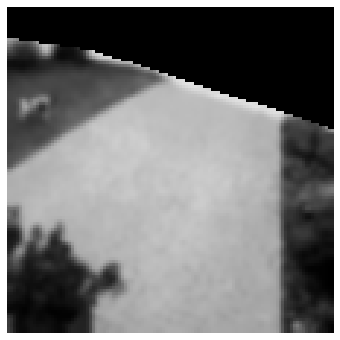

*************


In [221]:
# test preprocessing
WIDTH, HEIGHT = 112, 112
POLY_VALUES = np.array([[0, 0], [1, 0], [1, 0.37], [0.5, 0.21], [0.25, 0.13], [0, 0.09]])  # poly-shape to mask
im_dir_anom = '../Datasets/anomalies_labelled/yes'
im_dir_normal = '../Datasets/anomalies_labelled/yes'
for f in os.listdir(im_dir_anom)[2:]:
    im_path = f'{im_dir_anom}/{f}'
    print(im_path)
    im_raw = cv2.imread(im_path)
    im_processed = process_frame(im_raw, (WIDTH, HEIGHT), is_gray=True, is_blur=True, is_thresh=False,
                                 is_polyfill=True, poly_values=POLY_VALUES, debug_poly=False)
    #imshow(im_raw)
    imshow(im_processed)
    print('*************')
    break

### Process images

Take `NUM_ROWS` random samples from the DataFrame and follow the pipeline:
- intialize numpy array (pre-allocate required memory)
- take samples from dataframe
- iterate through samples and for each data point:
    - open image based on date and filename
    - resize image
    - convert to gray scale
    - add to numpy data structure
- print useful statistics about data shape and size
- save numpy array on the disk in an efficient, binary format

### Prepare training set

### Define autoencoder architecture

Inspired by [PyImageSearch blog](https://www.pyimagesearch.com/2020/03/02/anomaly-detection-with-keras-tensorflow-and-deep-learning/)